<a href="https://colab.research.google.com/github/rrl7012005/Tensor-Flow-Computer-Vision-Course/blob/main/YOLO_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Object Detection involves detecting the location of the object, perhaps what type of object it is, and placing a bounding box around the object. Can do for multiple objects in an image.

Typically the origin is taken as the top left corner of the input. The output is typically one hot encoded of each object, followed by parameters of the bounding boxes.

The bounding boxes can be represented by the coordinates of the bottom left and top right coordinates, or by the coordinates of the center of the box and the width and the height.

#YOLO

In the past, object detection models followed a pipeline of determining proposed regions of the image which may contain objects, extract featrues via a CNN, and the classify each region.

You Only Look Once method is a single network that runs a single CNN which generates the bounding boxes and class probabilities.

YOLO is fast, it can process images in real-time at 45fps and a smaller model can do 155 fps.

Before we had sliding window techniques, where a window is slid through the whole image, but YOLO passes the whole image, so it implicitly encodes contextual informaation about classes as well as their appearance.

There also exists other methods like R-CNN which can be more accurate but slower, its regional convolutional neural networks analyzing sections of images.

The training data is labelled with outputs, i.e. the class and bounding box of each major object.

Suppose we have 224 x 224 images and break each up into grid cells (like patches). For the output, for each patch we will provide an output. For each patch we will output perhaps 1 if theres an object, a 0 if theres no object (i.e. does the center of a bounding box fall in that cell). So now we know where the centers are, now we need to know the exact location of the bounding boxes, which we can represent with coordinates. For the x and y coordinates of the centers, we identify the grid cell the coordinate lies in. Treat that patch as a unit square, and the x and y coordinate of the center will be according to that convention. Also the width and height is divided by the image width and height. The next part is determining the class, so we output a confidence score over each class as well. If multiple objects in the same cell we get multiple entries.

If we break it into 49 patches, and have 20 classes then we will have a 7x7x25 output. Each cell in the YOLO model has 2 bounding boxes so up to 2 objects can be detected per cell, useful if 2 objects have their centers in the same cell. Then for each image we will have a 7x7x30 output.

The YOLO consists of a CNN feature extractor followed by a fully connected layer.

the feature extractor was pre trained on image net, then the FC layers were added and 4 more conv layers. The resolution was increased to 448x448 for finer visual info to improve detection. The final layer uses linear activation, the others use leaky relu. The loss function is the sum squared error (like a regression problem). If only one object exists in a cell, we expect both bounding boxes to point to that. To determine which bounding box is responsible for a prediction in training, calculate the IOU (intersection over union) for each box wrt to the true (training box). Also we need our loss function to reflect that small changes in bounding box are less important for larger boxes, so in order to do that we predict the square root of the width and height instead.

Learning rate is scheduled as well, see the original paper for additional modifications.

This is YOLO v1, later versions change the model slightly.

Now lets build YOLO from scratch, we will use the Pascal VOC dataset.

#Data Processing

In [ ]:
!pip install opendatasets -q
import opendatasets as od

od.download('https://www.kaggle.com/datasets/huanghanchina/pascal-voc-2012')

Dataset URL: https://www.kaggle.com/datasets/huanghanchina/pascal-voc-2012


100%|██████████| 3.63G/3.63G [00:52<00:00, 73.8MB/s]


We want to sort the directories so that  we have a folder called /content/dataset.VOC2012 and then inside that folder we have train_images and train_maps and val_images and val_maps folder

In [ ]:
!mkdir /content/dataset
!mkdir /content/dataset/VOC2012
!mkdir /content/dataset/VOC2012/JPEGImages
!mkdir /content/dataset/VOC2012/Annotations
!mkdir /content/dataset/VOC2012/ValJPEGImages
!mkdir /content/dataset/VOC2012/ValAnnotations

Now we will move the validation images, which we will choose, to the apppriopriate folder and while we're at it move the training images to the folder.

In [ ]:
val_list=['2007_000027.jpg','2007_000032.jpg','2007_000033.jpg','2007_000039.jpg','2007_000042.jpg','2007_000061.jpg',
          '2007_000063.jpg','2007_000068.jpg','2007_000121.jpg','2007_000123.jpg','2007_000129.jpg','2007_000170.jpg',
          '2007_000175.jpg','2007_000187.jpg','2007_000241.jpg','2007_000243.jpg','2007_000250.jpg','2007_000256.jpg',
          '2007_000272.jpg','2007_000323.jpg','2007_000332.jpg','2007_000333.jpg','2007_000346.jpg','2007_000363.jpg',
          '2007_000364.jpg','2007_000392.jpg','2007_000423.jpg','2007_000452.jpg','2007_000464.jpg','2007_000480.jpg',
          '2007_000491.jpg','2007_000504.jpg','2007_000515.jpg','2007_000528.jpg','2007_000529.jpg','2007_000549.jpg',
          '2007_000559.jpg','2007_000572.jpg','2007_000584.jpg','2007_000629.jpg','2007_000636.jpg','2007_000645.jpg',
          '2007_000648.jpg','2007_000661.jpg','2007_000663.jpg','2007_000664.jpg','2007_000676.jpg','2007_000713.jpg',
          '2007_000720.jpg','2007_000727.jpg','2007_000733.jpg','2007_000738.jpg','2007_000762.jpg','2007_000768.jpg',
          '2007_000783.jpg','2007_000793.jpg','2007_000799.jpg','2007_000804.jpg','2007_000807.jpg','2007_000822.jpg',
          '2007_001299.jpg','2007_001311.jpg','2007_001321.jpg','2007_001340.jpg']

In [ ]:
import shutil
import os

train_images='/content/dataset/VOC2012/JPEGImages/'
train_maps='/content/dataset/VOC2012/Annotations/'

val_images='/content/dataset/VOC2012/ValJPEGImages/'
val_maps='/content/dataset/VOC2012/ValAnnotations/'

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

B = 2
N_CLASSES = len(classes)
H, W = 224, 224
SPLIT_SIZE = H // 32
print(SPLIT_SIZE)
N_EPOCHS = 135
BATCH_SIZE = 32

for name in os.listdir('/content/pascal-voc-2012/voc2012/VOC2012/Annotations'):
  shutil.move('/content/pascal-voc-2012/voc2012/VOC2012/Annotations/' + name, train_maps + name)

for name in os.listdir('/content/pascal-voc-2012/voc2012/VOC2012/JPEGImages/'):
  shutil.move('/content/pascal-voc-2012/voc2012/VOC2012/JPEGImages/' + name, train_images + name)

for name in val_list:
  shutil.move(train_images + name, val_images + name)
  shutil.move(train_maps + name.replace('.jpg','.xml'), val_maps + name.replace('.jpg','.xml'))

7


Now we need to preprocess our annotations i.e extract the bounding boxes from this xml data. To do this we read the XML file (parse) using
xml.etree.ElementTree ET.parse() this creats an element tree object representing the entire structrue of the XML file in memory. Then we get the root top level element which usually ends up being the annotation.

In [ ]:
import tensorflow as tf
import xml.etree.ElementTree as ET
import numpy as np

In [ ]:
def preprocess_xml(filename):
  tree = ET.parse(filename)
  root = tree.getroot()
  size_tree = root.find('size') #size of object

  height = float(size_tree.find('height').text)
  width = float(size_tree.find('width').text)

  bounding_boxes = []

  #Find all objects and iterate over all bounding boxes
  for object_tree in root.findall('object'):
    for bounding_box in object_tree.iter('bndbox'):
      xmin = (float(bounding_box.find('xmin').text))
      ymin = (float(bounding_box.find('ymin').text))
      xmax = (float(bounding_box.find('xmax').text))
      ymax = (float(bounding_box.find('ymax').text))
      break

    class_name = object_tree.find('name').text
    class_dict = {classes[i]:i for i in range(len(classes))}

    #Extract the centers
    bounding_box = [
        (xmin + xmax) / (2 * width), #center coordinate normalized
        (ymin + ymax) / (2 * height),
        (xmax - xmin) / width,
        (ymax - ymin) / height,
        class_dict[class_name]
    ]

    bounding_boxes.append(bounding_box)

  return tf.convert_to_tensor(bounding_boxes)


preprocess_xml(val_maps + '2007_000027.xml')

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[ 0.53806585,  0.452     ,  0.3600823 ,  0.5       , 14.        ]],
      dtype=float32)>

Lets generate the required format for the output labels for the TRAINING SET. Recall here we only need to say whether or not there is a bounding box.

In [ ]:
def generate_output(bounding_boxes):
  output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))
  for b in range(len(bounding_boxes)):
    #Re-normalize the coordinate center to be per patch

    grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
    grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE
    i = int(grid_x)
    j = int(grid_y)

    output_label[i, j, 0:5] = [1.0, grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
    output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1

  return tf.convert_to_tensor(output_label, tf.float32)

generate_output(preprocess_xml(val_maps + '2007_000027.xml'))[3][3]

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([1.        , 0.7664609 , 0.16400003, 0.3600823 , 0.5       ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)>

Now we can use from tensor slices to extract file paths and convert it into a tensorflow dataset, but for that we need the image paths and the xml paths and then map it to the image processing stuff we did. So everything we did applied to our dataset but first extract image paths.

In [ ]:
im_paths, xml_paths, val_im_paths, val_xml_paths = [], [], [], []

for i in os.listdir(train_maps):

  im_paths.append(train_images + i.replace('.xml','.jpg'))
  xml_paths.append(train_maps + i)

for i in os.listdir(val_maps):

  val_im_paths.append(val_images + i.replace('.xml','.jpg'))
  val_xml_paths.append(val_maps + i)

print(len(im_paths), len(xml_paths), len(val_im_paths), len(val_xml_paths))

17061 17061 64 64


17061 training sets, 64 validation sets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((im_paths, xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths, val_xml_paths))

In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValJPEGImages/2007_000636.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/VOC2012/ValAnnotations/2007_000636.xml'>)


Now create the extract output bounding box function

In [ ]:
def preprocess(im_path, xml_path):
  im = tf.io.decode_jpeg(tf.io.read_file(im_path))
  im = tf.cast(tf.image.resize(im, [H, W]), tf.float32)

  bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  output = tf.numpy_function(func=generate_output, inp=[bboxes], Tout=tf.float32)
  return im, output

#Data Augmentation

without augmentation, run below

In [ ]:
train_dataset = (
  train_dataset.
  map(preprocess).
  shuffle(1000).
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)



val_dataset = (
  val_dataset.
  map(preprocess).
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

We can use albumentations to compose our data augmentation transforms. Albumentations has a bbox_params for bounding boxes. When scaling, rotating, flipping, or cropping, bounding boxes must be updated to reflect these changes. Specifying it to be 'yolo' will normalize it for yolo format so no need to do the generate output function.

In [ ]:
import albumentations as A
import cv2

transforms = A.Compose([
    A.Resize(H, W),
    A.RandomCrop(width=np.random.randint(int(0.9 * W), W),
                 height=np.random.randint(int(0.9 * H), H), p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=cv2.INTER_LANCZOS4, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Resize(H, W)
], bbox_params=A.BboxParams(format='yolo')) #augment the boxes as well

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
def aug_albument(image, bboxes):
  augmented = transforms(image=image, bboxes=bboxes)
  return [tf.convert_to_tensor(augmented['image'], tf.float32),
          tf.convert_to_tensor(augmented['bboxes'], tf.float32)]

def preprocess_albument(im_path, xml_path):
  im = tf.io.decode_jpeg(tf.io.read_file(im_path))
  im = tf.cast(tf.image.resize(im, [H, W]), tf.float32)

  bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)

  aug = tf.numpy_function(func=aug_albument, inp=[im, bboxes], Tout=(tf.float32, tf.float32))
  return aug[0], aug[1]

Or we can use tf.image for our augmentations

In [ ]:
def preprocess_augment(im_path, xml_path):

  im = tf.io.decode_jpeg(tf.io.read_file(im_path))
  im = tf.cast(tf.image.resize(im, [H, W]), tf.float32)

  im = tf.image.random_brightness(im, max_delta=50.0)
  im = tf.image.random_saturation(im, lower=0.5, upper=1.5)
  im = tf.image.random_contrast(im, lower=0.5, upper=1.5)
  im = tf.clip_by_value(im, 0, 255)

  bboxes = tf.numpy_function(func=preprocess_xml, inp=[xml_path], Tout=tf.float32)
  output = tf.numpy_function(func=generate_output, inp=[bboxes], Tout=tf.float32)
  return im, output

with augmentation run below

In [ ]:
#Albumentation

train_dataset=(
  train_dataset.
  map(preprocess_albument).
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)


val_dataset=(
  val_dataset.
  map(preprocess_albument).
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

TypeError: in user code:

    File "<ipython-input-15-4c4f63d7387e>", line 7, in preprocess_albument  *
        im = tf.io.decode_jpeg(tf.io.read_file(im_path))

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [ ]:
#Tf image augmentation


train_dataset=(
  train_dataset.
  map(preprocess_augment).
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)


val_dataset=(
  val_dataset.
  map(preprocess_augment).
  batch(BATCH_SIZE).
  prefetch(tf.data.AUTOTUNE)
)

Testing

In [ ]:
for i, j in train_dataset.take(1):
  print(i[0], j[0])

tf.Tensor(
[[[107.853195   94.2119     83.99263  ]
  [111.41091    98.93635    84.99864  ]
  [107.16071    98.20017    83.26598  ]
  ...
  [106.672676   98.76828    88.13954  ]
  [121.77367   101.54754    84.98056  ]
  [122.28669   103.13785    83.07585  ]]

 [[106.7335     97.27969    88.27969  ]
  [111.914185  101.12401    92.12401  ]
  [115.23051   106.39122    98.78408  ]
  ...
  [105.424095   96.82586    88.99883  ]
  [125.00403   103.36097    86.558205 ]
  [121.775185  100.63835    85.20398  ]]

 [[110.27376    93.41849    80.34706  ]
  [111.73115   103.124      91.51686  ]
  [124.47409   114.15266   103.77766  ]
  ...
  [107.74954    93.82182    85.77185  ]
  [120.206314   98.17178    85.31679  ]
  [119.02715    99.19942    89.09157  ]]

 ...

 [[146.25069    27.31955     2.4988415]
  [150.43417    28.854979    4.8549786]
  [154.29155    29.581266    1.5812663]
  ...
  [152.64282   175.20886   197.71468  ]
  [156.09718   184.5045    207.46225  ]
  [ 73.18146    83.806274   64.79

Write the image on a file

In [ ]:
import cv2

cv2.imwrite('out_2.jpg',np.array(i[0]))

True

#Model

In [ ]:
NUM_FILTERS = 512
OUTPUT_DIM = N_CLASSES + 5 * B

For the pretrained feature extractor use efficient net. Then build the rest of the model, we rearrange the bottom. Note global average pooling loses positional information, so we use flatten.

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=(H, W, 3),
)

base_model.trainable = False

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(H, W, 3))
x = base_model(inputs, training=False)

x = layers.Conv2D(NUM_FILTERS, (3, 3), padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(NUM_FILTERS, (3, 3), padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(NUM_FILTERS, (3, 3), padding='same', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(NUM_FILTERS, (3, 3), padding='same', kernel_initializer='he_normal')(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Flatten()(x)

x = layers.Dense(NUM_FILTERS, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM, activation='sigmoid')(x)
outputs = layers.Reshape((SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb1 (Functional)          │ (None, 7, 7, 1280)          │       6,575,239 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 512)           │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1470)                │         754,110 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,161,285 (126.50 MB)

 Trainable params: 26,581,950 (101.40 MB)

 Non-trainable params: 6,579,335 (25.10 MB)

**Loss function**

We need to build this extremely complicated loss function

The loss function composes of classification loss: the squared error of the class conditional probabilities for each class. The localization loss: measuring the errors in the predicted boundary box locations and sizes (note the square root prediction). To put more emphasis on the bounding box accuracy we multiple by lambda_coord which is 5 by default. The confidence loss: measuring whether or not there is an object in the box, if no object we weigh down the loss by lambda_noobj because most boxes will not contain any objects, so we address class imbalance (default) 0.5.




<img src='https://drive.google.com/uc?id=1J1-Pqa7ufpEl0Dagaq65Ld5L5U8-FiZ2'>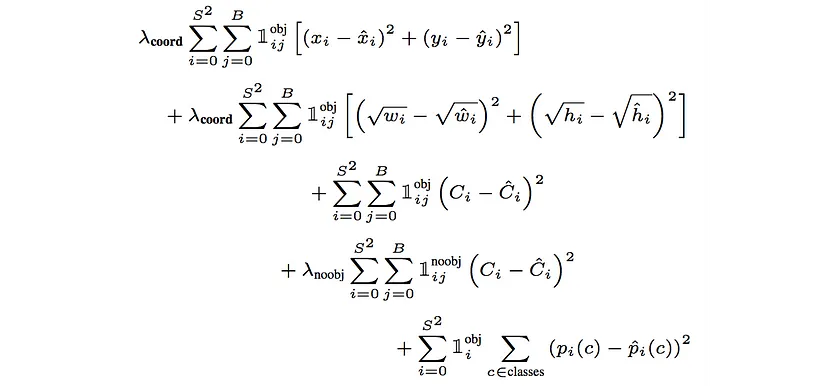

First start with the object loss. y_true is in the format batch size, grid size, grid, size, num_channels. target is a tensor of size (B, G, G) where its 1 wherever theres an object, 0 otherwise. Recall our yolo model predicts 2 bounding boxes, now whichever bounding box we compare to our true bounding box will be whichever is closer, in other words whichever the IOU is higher. But recall the values of coordinates in the channel were scaled by split size so aren't the true coordinates, so we need to fix that.

In [ ]:
def difference(x,y):
  return tf.reduce_sum(tf.square(y-x))

In [ ]:
def yolo_loss(y_true, y_pred):
  target = y_true[..., 0] #(B, G, G)

  #Object loss, get all positions where there are objects
  y_pred_extract = tf.gather_nd(y_pred, tf.where(target[:] == 1)) #all channels with obj
  y_target_extract = tf.gather_nd(y_true, tf.where(target[:] == 1)) #all channels with obj

  #Rescale
  rescaler = tf.where(target[:] == 1) * SPLIT_SIZE #gives true coord of top left corner of grid cell
  #concatenate 2 zeros for the width and height, remove the batch dimension so start from 1
  upscaler_1 = tf.concat([rescaler[:, 1:], tf.zeros([tf.shape(rescaler)[0], 2], dtype=tf.int64)], axis=-1)

  #now we multiply the grid coords by 32 for x, y to get the dist from grid edge in pixels and 224 to get true width and height

  #Upscale the target and each of the predictions
  target_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                       repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_target_extract[...,1:5], dtype = tf.float32)
  pred_1_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_pred_extract[...,1:5], dtype = tf.float32)
  pred_2_upscaler_2 = tf.repeat([[float(SPLIT_SIZE),float(SPLIT_SIZE),H,W]],
                      repeats=[tf.shape(rescaler)[0]], axis=0)*tf.cast(y_pred_extract[...,6:10], dtype = tf.float32)

  #Now add the grid coords to get the true coords of center

  target_orig = tf.cast(upscaler_1, dtype = tf.float32) + target_upscaler_2
  pred_1_orig = tf.cast(upscaler_1, dtype = tf.float32) + pred_1_upscaler_2
  pred_2_orig = tf.cast(upscaler_1, dtype = tf.float32) + pred_2_upscaler_2

  #Now we can compute iou, which is greater is our mask (the indices of the pred we use)

  mask = tf.cast(tf.math.greater(compute_iou(target_orig,pred_2_orig),
                                         compute_iou(target_orig,pred_1_orig)),dtype=tf.int32)

  #combine to list the joint predictions
  y_pred_joined = tf.transpose(tf.concat(
      [tf.expand_dims(y_pred_extract[..., 0], axis=0),
       tf.expand_dims(y_pred_extract[...,5], axis=0)], axis=0))

  #Then use the mask to select which pred to be used for the prediction

  obj_pred = tf.gather_nd(y_pred_joined,
                          tf.stack([tf.range(tf.shape(rescaler)[0]), mask], axis=-1))

  #Where difference is sum of squared errors
  object_loss = difference(tf.cast(obj_pred,dtype =tf.float32)
                            ,tf.cast(tf.ones([tf.shape(rescaler)[0]]),dtype=tf.float32))

  #Now the rest should be self explanable, no object

  y_pred_extract = tf.gather_nd(y_pred[..., 0:B*5], tf.where(target[:] == 0))
  y_target_extract = tf.zeros(tf.shape(y_pred_extract)[0])

  no_object_loss_1 = difference(tf.cast(y_pred_extract[..., 0], dtype = tf.float32)
                            , tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss_2 = difference(tf.cast(y_pred_extract[...,5], dtype = tf.float32)
                            , tf.cast(y_target_extract,dtype=tf.float32))

  no_object_loss = no_object_loss_1 + no_object_loss_2

  #Now for bounding box loss, self explanable

  y_pred_extract = tf.gather_nd(y_pred[..., 0:B*5], tf.where(target[:] == 1))
  centre_joined = tf.stack([y_pred_extract[..., 1:3], y_pred_extract[..., 6:8]], axis=1) #join center coords
  centre_pred = tf.gather_nd(centre_joined, tf.stack([tf.range(tf.shape(rescaler)[0]), mask], axis=-1))
  centre_target = tf.gather_nd(y_true[..., 1:3], tf.where(target[:] == 1))

  centre_loss = difference(centre_pred,centre_target) #box loss is center loss and size loss

  size_joined = tf.stack([y_pred_extract[...,3:5], y_pred_extract[...,8:10]], axis=1)

  size_pred = tf.gather_nd(size_joined, tf.stack([tf.range(tf.shape(rescaler)[0]), mask], axis=-1))
  size_target = tf.gather_nd(y_true[...,3:5], tf.where(target[:]==1))

  size_loss = difference(tf.math.sqrt(tf.math.abs(size_pred)), tf.math.sqrt(tf.math.abs(size_target)))
  box_loss = centre_loss + size_loss

  #Now loss for the class prediction

  y_pred_extract = tf.gather_nd(y_pred[...,10:], tf.where(target[:] == 1))
  class_extract = tf.gather_nd(y_true[...,5:], tf.where(target[:] == 1))

  class_loss = difference(tf.cast(y_pred_extract, dtype = tf.float32)
                                , tf.cast(class_extract, dtype = tf.float32))

  #Put it all together

  lambda_coord = 5.0
  lambda_no_obj = 0.5

  loss = object_loss + (lambda_no_obj * no_object_loss) + tf.cast(lambda_coord * box_loss, dtype=tf.float32) \
        + tf.cast(class_loss, dtype=tf.float32)

  return loss

Compute intersection over union areas

In [ ]:
def compute_iou(boxes1, boxes2):

  #First we obtain the corner coordinates

  boxes1_t = tf.stack([boxes1[..., 0] - boxes1[..., 2] / 2.0, #Take away half width
                        boxes1[..., 1] - boxes1[..., 3] / 2.0, #Take half height
                        boxes1[..., 0] + boxes1[..., 2] / 2.0, #Add half width
                        boxes1[..., 1] + boxes1[..., 3] / 2.0], #Add half height
                        axis=-1)

  boxes2_t = tf.stack([boxes2[..., 0] - boxes2[..., 2] / 2.0,
                        boxes2[..., 1] - boxes2[..., 3] / 2.0,
                        boxes2[..., 0] + boxes2[..., 2] / 2.0,
                        boxes2[..., 1] + boxes2[..., 3] / 2.0],
                      axis=-1)

  lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2]) #upper left corner of the intersection (which box is resp for that)
  rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:]) #bottom right corner of intersection (which box is resp for that)

  intersection = tf.maximum(0.0, rd - lu) #width and height of intersection if it exists
  intersection_area = intersection[..., 0] * intersection[..., 1]

  boxes1_area = boxes1[..., 2] * boxes1[..., 3] #width and height
  boxes2_area = boxes2[..., 2] * boxes2[..., 3]

  union_area = tf.maximum(boxes1_area + boxes2_area - intersection_area, 1e-10) #avoid 0 div error
  iou = tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

  return iou

**Callbacks**

We schedule the learning rate exactly as in the paper, and also add a checkpoint callback.

In [ ]:
checkpoint_filepath='/content/yolo_efficientnet_b1_new.weights.h5'

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)



def scheduler(epoch, lr):
  if epoch < 40:
    return 1e-3
  elif epoch>=40 and epoch<80:
    return 5e-4
  else:
    return 1e-4


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model.compile(
  loss=yolo_loss,
  optimizer=tf.keras.optimizers.Adam(1e-3),
  run_eagerly=True
) #Have to run eagerly graph mode bugs out


history = model.fit(train_dataset, validation_data=val_dataset, verbose=1,
                    epochs=135, callbacks=[lr_callback, callback])

Epoch 1/135
 62/534 ━━━━━━━━━━━━━━━━━━━━ 10:54 1s/step - loss: 461.9901

KeyboardInterrupt: 

#Testing and Visualizing

Use the COCO 2017 dataset for testing

In [ ]:
!mkdir outputs/

In [ ]:
image_dir = None

def model_test(filename):
  try:
    test_path = image_dir + filename

    print(test_path)

    img = cv2.resize(cv2.imread(test_path), (H, W))

    image = tf.io.decode_jpeg(tf.io.read_file(test_path), channels=3)
    image = tf.image.resize(image, [H, W])

    output = model.predict(np.expand_dims(image, axis=0))

    THRESH = 0.25

    object_positions = tf.concat([tf.where(output[..., 0] >= THRESH),
                                  tf.where(output[..., 5] >= THRESH)], axis=0)

    print(object_positions)

    selected_output = tf.gather_nd(output, object_positions)

    print(selected_output)

    final_boxes, final_scores = [], []

    for i, pos in enumerate(object_positions):
      for j in range(2):
        if selected_output[i][j * 5] > THRESH:
          output_box = tf.cast(output[pos[0]][pos[1]][pos[2]][(j * 5) + 5], dtype=tf.float32)

          x_centre=(tf.cast(pos[1],dtype=tf.float32)+output_box[0])*32
          y_centre=(tf.cast(pos[2],dtype=tf.float32)+output_box[1])*32

          x_width,y_height=tf.math.abs(H*output_box[2]),tf.math.abs(W*output_box[3])

          x_min,y_min=int(x_centre-(x_width/2)),int(y_centre-(y_height/2))
          x_max,y_max=int(x_centre+(x_width/2)),int(y_centre+(y_height/2))

          if(x_min<=0):x_min=0
          if(y_min<=0):y_min=0
          if(x_max>=W):x_max=W
          if(y_max>=H):y_max=H

          final_boxes.append(
              [x_min,y_min,x_max,y_max,
              str(classes[tf.argmax(selected_output[...,10:],axis=-1)[i]])])
          final_scores.append(selected_output[i][j*5])

    print(final_scores)
    print('finalboxes',final_boxes)
    final_boxes=np.array(final_boxes)

    object_classes=final_boxes[...,4]
    nms_boxes=final_boxes[...,0:4]

    nms_output=tf.image.non_max_suppression(
        nms_boxes,final_scores,max_output_size=100,iou_threshold=0.2,
        score_threshold=float('-inf')
    )
    print(nms_output)

    for i in nms_output:
      cv2.rectangle(
          img,
          (int(final_boxes[i][0]),int(final_boxes[i][1])),
          (int(final_boxes[i][2]),int(final_boxes[i][3])),(0,0,255),1)
      cv2.putText(
          img,
          final_boxes[i][-1],
          (int(final_boxes[i][0]),int(final_boxes[i][1])+15),
          cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(2,225,155),1
          )

    cv2.imwrite('/content/outputs/' + filename[:-4] + '_det.jpg', cv2.resize(img, (384, 384)))
  except:
    print("NO OBJECT FOUND")

Note the above code does not run in graph mode, only eagerly. The below code runs in graph mode.

In [ ]:
classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable',
         'dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
NUM_CLASSES = len(classes)
OUTPUT_DIM = B * 5 + NUM_CLASSES  # B = number of bounding boxes per cell


def parse_xml(xml_path):
    xml_content = tf.io.read_file(xml_path)

    def _parse_xml(content):
        import xml.etree.ElementTree as ET
        import numpy as np

        content = content.numpy().decode('utf-8')
        root = ET.fromstring(content)
        size = root.find('size')
        width = float(size.find('width').text)
        height = float(size.find('height').text)

        bboxes = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            class_id = class_to_idx.get(label, -1)
            if class_id == -1:
                continue

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text) / width
            ymin = float(bndbox.find('ymin').text) / height
            xmax = float(bndbox.find('xmax').text) / width
            ymax = float(bndbox.find('ymax').text) / height

            x_center = (xmin + xmax) / 2.0
            y_center = (ymin + ymax) / 2.0
            box_width = xmax - xmin
            box_height = ymax - ymin

            bboxes.append([x_center, y_center, box_width, box_height, class_id])

        return np.array(bboxes, dtype=np.float32)

    bboxes = tf.py_function(_parse_xml, [xml_content], tf.float32)
    bboxes.set_shape([None, 5])

    return bboxes



In [ ]:
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [H, W])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image


In [ ]:
def augment_image(image, bboxes):
    # Random horizontal flip
    def flip_image_and_bboxes():
        flipped_image = tf.image.flip_left_right(image)
        x_centers = bboxes[:, 0]
        bboxes_flipped = tf.stack([
            1.0 - x_centers,
            bboxes[:, 1],
            bboxes[:, 2],
            bboxes[:, 3],
            bboxes[:, 4]
        ], axis=-1)
        return flipped_image, bboxes_flipped

    do_flip = tf.random.uniform([]) > 0.5
    image, bboxes = tf.cond(do_flip, flip_image_and_bboxes, lambda: (image, bboxes))

    return image, bboxes


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
def create_grid_labels(bboxes):
    labels = tf.zeros([SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM], dtype=tf.float32)

    num_boxes = tf.shape(bboxes)[0]

    def loop_body(i, labels):
        bbox = bboxes[i]

        # Unpack bbox elements
        x_center, y_center, width, height, class_id = tf.unstack(bbox, num=5)
        class_id = tf.cast(class_id, tf.int32)

        # Calculate grid cell indices
        cell_x = tf.cast(tf.floor(x_center * SPLIT_SIZE), tf.int32)
        cell_y = tf.cast(tf.floor(y_center * SPLIT_SIZE), tf.int32)
        cell_x = tf.clip_by_value(cell_x, 0, SPLIT_SIZE - 1)
        cell_y = tf.clip_by_value(cell_y, 0, SPLIT_SIZE - 1)

        # Relative positions within the cell
        rel_x = x_center * SPLIT_SIZE - tf.cast(cell_x, tf.float32)
        rel_y = y_center * SPLIT_SIZE - tf.cast(cell_y, tf.float32)

        # Prepare label vector with OUTPUT_DIM length
        # Assign values to the first bounding box predictor (indices 0-4)
        bbox_info1 = tf.stack([1.0, rel_x, rel_y, width, height])  # Shape: [5]
        # Second bounding box predictor remains zeros (indices 5-9)
        bbox_info2 = tf.zeros([5], dtype=tf.float32)  # Shape: [5]
        # Class probabilities (indices 10-OUTPUT_DIM)
        class_one_hot = tf.one_hot(class_id, NUM_CLASSES)  # Shape: [NUM_CLASSES]

        # Concatenate to form the label vector
        label = tf.concat([bbox_info1, bbox_info2, class_one_hot], axis=0)  # Shape: [OUTPUT_DIM]

        # Update labels tensor at the specific cell
        indices = [[cell_y, cell_x]]
        updates = [label]
        labels = tf.tensor_scatter_nd_update(labels, indices, updates)

        return i + 1, labels

    i = tf.constant(0)
    _, labels = tf.while_loop(lambda i, labels: i < num_boxes, loop_body, [i, labels])

    return labels


In [ ]:
def preprocess_sample(image_path, xml_path):
    image = load_and_preprocess_image(image_path)
    bboxes = parse_xml(xml_path)
    image, bboxes = augment_image(image, bboxes)
    labels = create_grid_labels(bboxes)
    return image, labels


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((im_paths, xml_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_im_paths, val_xml_paths))

train_dataset = (train_dataset.
                 map(preprocess_sample, num_parallel_calls=tf.data.AUTOTUNE).
                 batch(BATCH_SIZE).
                 prefetch(tf.data.AUTOTUNE))

val_dataset = (val_dataset.
                 map(preprocess_sample, num_parallel_calls=tf.data.AUTOTUNE).
                 batch(BATCH_SIZE).
                 prefetch(tf.data.AUTOTUNE))


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def create_model(input_shape=(H, W, 3)):
    # Load EfficientNetB0 without the top layers
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')

    # Optionally freeze the base model
    base_model.trainable = True  # Set to False if you want to freeze the backbone

    # Extract features
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # YOLO custom layers
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM)(x)
    outputs = layers.Reshape((SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

model = create_model()


In [ ]:
def yolo_loss(y_true, y_pred):
    lambda_coord = 5.0
    lambda_noobj = 0.5

    # Object mask
    object_mask = y_true[..., 0]  # Shape: (batch_size, S, S)
    object_mask = tf.expand_dims(object_mask, axis=-1)  # Shape: (batch_size, S, S, 1)

    # No object mask
    no_object_mask = 1.0 - object_mask

    # Extract true and predicted boxes
    true_boxes = y_true[..., 1:5]  # Shape: (batch_size, S, S, 4)
    pred_boxes = y_pred[..., 1:5]

    # Extract true and predicted class probabilities
    true_class_probs = y_true[..., 5:]  # Shape: (batch_size, S, S, num_classes)
    pred_class_probs = y_pred[..., 5:]

    # Coordinate loss (only where object exists)
    coord_loss = lambda_coord * tf.reduce_sum(
        object_mask * tf.square(true_boxes - pred_boxes)
    )

    # Object loss
    object_loss = tf.reduce_sum(
        object_mask * tf.square(y_pred[..., 0:1] - y_true[..., 0:1])
    )

    # No object loss
    no_object_loss = lambda_noobj * tf.reduce_sum(
        no_object_mask * tf.square(y_pred[..., 0:1])
    )

    # Class probability loss (only where object exists)
    class_loss = tf.reduce_sum(
        object_mask * tf.square(true_class_probs - pred_class_probs)
    )

    total_loss = coord_loss + object_loss + no_object_loss + class_loss
    return total_loss


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=yolo_loss)

# Train the model
model.fit(train_dataset, validation_data=val_dataset, verbose=1, epochs=10)


Epoch 1/10


KeyboardInterrupt: 